This is a notebook that just does some preliminary visualization work on the initial data. Helpful for just seeing if the data needs any normalization or any prior work prior to inputting to model. This first section is just for the aging eye data + any imports I need to do. 


In [111]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import gffutils
import pyranges as pr
from sklearn.model_selection import train_test_split

### Mouse DiffEq
This next section is for the mouse differential gene expression data. Taken from this following paper: https://www.nature.com/articles/s43587-023-00513-y#data-availability. 

In [3]:
cts_file = '../../0-data/1-experimental/counts/mouse/GSE132040_190214_A00111_0269_AHH3J3DSXX_190214_A00111_0270_BHHMFWDSXX.csv'
md_file = '../../0-data/1-experimental/counts/mouse/GSE132040_MACA_Bulk_metadata.csv'
mouse_counts = pd.read_csv(cts_file)
mouse_metadata = pd.read_csv(md_file)
mouse_counts.shape

(54357, 948)

In [4]:
 ## Preprocess the sample labels to match the metadata from which we will extract ages from 
cur_headers, new_cols = mouse_counts.columns, []
mouse_counts.head(3) # <- before 
for i, entry in enumerate(cur_headers): 
    split = entry.split('.') 
    new_cols.append(split[0]) 
mouse_counts.columns = new_cols
mouse_counts.head(3) # <- after 
# print(mouse_counts.shape) # SHAPE: (54,357, 948)

,gene,A10_384Bulk_Plate1_S10,A10_384Bulk_Plate2_S10,A10_384Bulk_Plate3_S10,A11_384Bulk_Plate1_S11,A11_384Bulk_Plate2_S11,A11_384Bulk_Plate3_S11,A12_384Bulk_Plate1_S12,A12_384Bulk_Plate2_S12,A12_384Bulk_Plate3_S12,...,P6_384Bulk_Plate3_S366,P7_384Bulk_Plate1_S367,P7_384Bulk_Plate2_S367,P7_384Bulk_Plate3_S367,P8_384Bulk_Plate1_S368,P8_384Bulk_Plate2_S368,P8_384Bulk_Plate3_S368,P9_384Bulk_Plate1_S369,P9_384Bulk_Plate2_S369,P9_384Bulk_Plate3_S369
0,0610005C13Rik,8,29,5,6,3,477,4,2494,7,...,19,7,5,1004,8,16,5,1,9,0
1,0610006L08Rik,9,0,23,0,3,3,5,0,17,...,9,0,0,97,9,10,2,7,7,0
2,0610009B22Rik,118,269,117,209,2,215,96,214,91,...,49,29,1118,136,178,161,3,10,112,2


In [5]:
## Metadata head
mouse_metadata.head() # <- Beforehand exploration 
mouse_age_sex = mouse_metadata[['Sample name', 'characteristics: age', 'characteristics: sex']]
mouse_age_sex.head() # <- After
print(mouse_age_sex.shape)
print("Age classes are: ", set(mouse_age_sex['characteristics: age'])) # 24 distinct ages to predict for 
print("Sex classes are: ", set(mouse_age_sex['characteristics: sex']))

no_na_age = mouse_age_sex[~mouse_age_sex['characteristics: age'].str.contains('NA')]
print(no_na_age.shape) # Only 15 samples had NA age 
no_na_sex =  mouse_age_sex[~mouse_age_sex['characteristics: sex'].str.contains('missing')]
print(no_na_sex.shape) # Same samples probably had NA sex too
no_na_age_sex = mouse_age_sex[~mouse_age_sex['characteristics: age'].str.contains('NA')]

concat_age_sex = pd.concat([no_na_age, no_na_sex])
print(concat_age_sex.shape)
concat_age_sex = concat_age_sex.drop_duplicates()
print(concat_age_sex.shape) # Implies all NA rows w/ age and all NA rows w/ sex were in fact the same rows
concat_age_sex.head()


(947, 3)
Age classes are:  {'NA2', 'NA5', 'NA9', 'NA13', '12', 'NA14', 'NA10', 'NA12', 'NA4', '1', 'NA1', '9', 'NA6', '3', '27', '6', '24', 'NA3', 'NA11', 'NA8', '18', '21', '15', 'NA7'}
Sex classes are:  {'missing', 'f', 'm'}
(933, 3)
(933, 3)
(1866, 3)
(933, 3)


,Sample name,characteristics: age,characteristics: sex
0,A1_384Bulk_Plate1_S1,6,m
1,A1_384Bulk_Plate3_S1,3,m
2,A10_384Bulk_Plate1_S10,18,m
3,A10_384Bulk_Plate2_S10,1,f
4,A10_384Bulk_Plate3_S10,12,f


The paper did differential expression analysis between mice ages of 3 and 18 months, so restrict to those criteria? Not sure. This section is for processing the counts matrix based on the metadata at hand. 

In [6]:
## Preprocessing
    # Our model formulation should do the following: 
        # 0. Filter out NAs 
        # 1. Match each sample -> sex. If sample not in concat_age_sex then discard 
        # 2. Groupby sex -> split between m and f
        # 3. Then assign ages to each sex (TODO)
            # Samples -> ages
            # Then have "labels" entry in DF where each is a np array of len(ages) within respective df
            # ...

# First, take your metadata DF and filter the counts dataframe by its listed sample names
to_filter = ['gene'] + concat_age_sex['Sample name'].tolist()
no_na_cts = mouse_counts.filter(items=to_filter, axis=1)
group_by_sex = pd.Series(concat_age_sex['characteristics: sex'].values, index=concat_age_sex['Sample name']).to_dict()
no_na_cts.loc['Sex'] = no_na_cts.columns.map(group_by_sex) # Create new row in DF that represents the sample -> sex mappings
no_na_cts_tp = no_na_cts.T
no_na_cts_tp.head()

,0,1,2,3,4,5,6,7,8,9,...,54348,54349,54350,54351,54352,54353,54354,54355,54356,Sex
gene,0610005C13Rik,0610006L08Rik,0610009B22Rik,0610009E02Rik,0610009L18Rik,0610010F05Rik,0610010K14Rik,0610012D04Rik,0610012G03Rik,0610025J13Rik,...,n-R5s97,n-R5s98,n-TSaga9,n-TStga1,__no_feature,__ambiguous,__too_low_aQual,__not_aligned,__alignment_not_unique,NaN
A1_384Bulk_Plate1_S1,4,1,118,1,2,208,13,0,550,18,...,0,0,0,0,1444139,428051,0,0,2067021,m
A1_384Bulk_Plate3_S1,29,7,238,11,37,570,123,2,593,12,...,1,0,0,5,12700679,531043,0,0,6207245,m
A10_384Bulk_Plate1_S10,8,9,118,8,17,546,39,6,284,6,...,0,5,2,5,10230901,312129,0,0,4520224,m
A10_384Bulk_Plate2_S10,29,0,269,19,40,570,113,2,488,6,...,2,0,0,0,6295065,652316,0,0,3925084,f


In [7]:
# Split the new dataframe by male and female mice
no_na_cts_tp.head()
new_genes = mouse_counts['gene'][:54357]
new_header = new_genes.tolist() + ['Sex']
male_only = no_na_cts_tp[no_na_cts_tp['Sex'] == 'm'] # 665 male samples
male_only.columns = new_header
female_only = no_na_cts_tp[no_na_cts_tp['Sex'] == 'f'] # 268 female samples 
female_only.columns = new_header

In [8]:
# Assign ages to each sex 
group_by_age = pd.Series(concat_age_sex['characteristics: age'].values, index=concat_age_sex['Sample name']).to_dict()
male_only['Age'] = male_only.index.map(group_by_age) # <- warning is triggered here, idrk what's going on
female_only['Age'] = female_only.index.map(group_by_age) # <- warning is triggered here, idrk what's going on

/var/folders/_c/xlv9fsg15_df99yllrpzxrw80000gn/T/ipykernel_78198/1610841261.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  male_only['Age'] = male_only.index.map(group_by_age) # <- warning is triggered here, idrk what's going on
/var/folders/_c/xlv9fsg15_df99yllrpzxrw80000gn/T/ipykernel_78198/1610841261.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  female_only['Age'] = female_only.index.map(group_by_age) # <- warning is triggered here, idrk what's going on


In [9]:
# Concatenate properly (get rid of NA rows for specific genes etc.) 
male_only = pd.concat([male_only.iloc[:, :54352], male_only.iloc[:, 54357:54359]], axis=1)
female_only = pd.concat([female_only.iloc[:, :54352], female_only.iloc[:, 54357:54359]], axis=1)

Female ages {'18', '21', '9', '12', '15', '3', '6', '1'}
Male ages {'18', '21', '9', '12', '15', '3', '27', '6', '24', '1'}


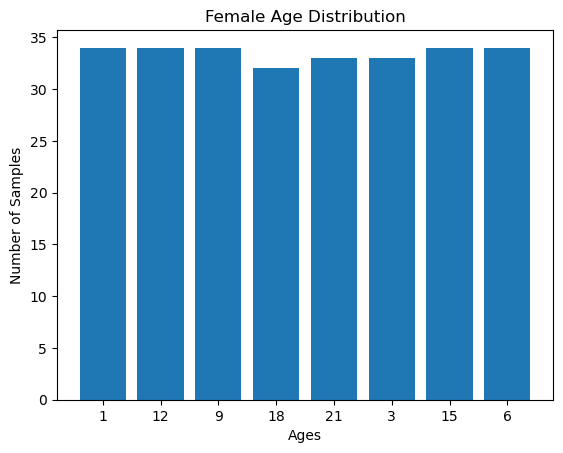

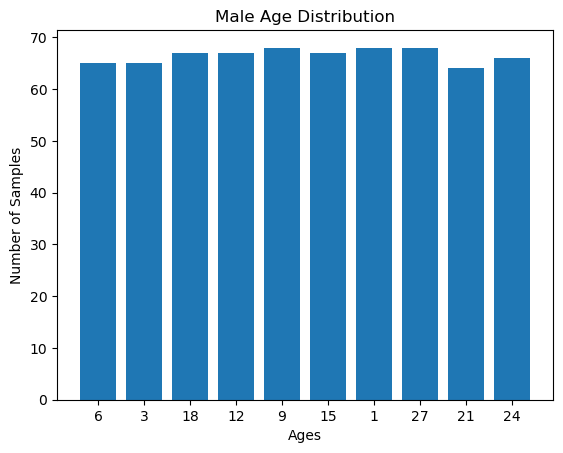

In [10]:
# TODO: Vectorize what I can in this following section
female_dict, male_dict = {}, {}
print('Female ages', set(female_only['Age'])) 
print('Male ages', set(male_only['Age']))

## Get age distribution (number of samples belonging to each age)
female_age_to_nums, male_age_to_nums = {}, {}
for age in female_only['Age']: 
    female_age_to_nums[age] = 1 + female_age_to_nums.get(age, 0) 
for age in male_only['Age']: 
    male_age_to_nums[age] = 1 + male_age_to_nums.get(age, 0)

# Plot distribution of ages across the samples (male, female)
plt.bar(list(female_age_to_nums.keys()), female_age_to_nums.values(), align='center')
plt.xlabel("Ages")
plt.ylabel("Number of Samples")
plt.title("Female Age Distribution")
plt.show()

plt.bar(list(male_age_to_nums.keys()), male_age_to_nums.values(), align='center')
plt.title("Male Age Distribution")
plt.ylabel("Number of Samples")
plt.xlabel("Ages")
plt.show()

In [11]:
# NOTE: Male dim: (665, 54354)
# NOTE: NON-VECTORIZED implementation (ignore)
# for sample_num, sample in enumerate(female_only.index): 
#     for gene_counts in female_only.iloc[sample_num,:54353]: 
#        female_counts_per_age['Age'] =  + female_counts_per_age.get(female_only.iloc[sample_num,54353], 0)    

# GROUPBY age -> get sum of counts PER gene 
female_counts_per_age = female_only.iloc[:, :54353].groupby(female_only.iloc[:, 54353]).sum()
male_counts_per_age = male_only.iloc[:, :54353].groupby(male_only.iloc[:, 54353]).sum()

In [12]:
# View the gene counts per age in order to get a sense of the distribution pre-normalization
female_counts_per_age
male_counts_per_age

,0610005C13Rik,0610006L08Rik,0610009B22Rik,0610009E02Rik,0610009L18Rik,0610010F05Rik,0610010K14Rik,0610012D04Rik,0610012G03Rik,0610025J13Rik,...,n-R5s92,n-R5s93,n-R5s94,n-R5s95,n-R5s96,n-R5s97,n-R5s98,n-TSaga9,n-TStga1,Sex
Age,,,,,,,,,,,,,,,,,,,,,
1,16908,1323,9089,505,1950,17200,2806,132,23200,362,...,9,49,32,36,12,103,91,12,53,mmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmm...
12,17858,994,8759,440,2009,16815,2269,135,23881,282,...,34,43,31,51,5,106,125,18,39,mmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmm...
15,19651,1167,8579,459,2380,17768,2428,130,23744,353,...,25,32,25,46,13,94,82,27,44,mmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmm...
18,19835,1325,8535,432,1890,15589,2575,133,21236,374,...,28,47,23,51,28,100,109,14,49,mmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmm...
21,14835,983,7482,438,2128,15077,2091,107,20427,245,...,9,26,37,34,13,92,88,5,31,mmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmm...
24,19507,1069,7107,346,1921,16050,2285,133,19330,294,...,14,34,23,29,27,108,132,11,48,mmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmm...
27,17342,1018,7286,391,1992,17152,2429,103,19423,324,...,32,50,28,28,6,105,127,21,72,mmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmm...
3,16995,1070,8445,364,2287,15854,2361,107,21279,246,...,16,24,27,51,12,64,71,13,37,mmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmm...
6,23464,1596,9063,426,1754,17031,2432,99,22645,433,...,12,29,16,47,5,104,131,21,72,mmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmm...


In [13]:
# Just get the new DFs & log normalize them both. Drop the Sex column bc its self-evident based on variable names
male_counts = pd.DataFrame(male_counts_per_age)
male_counts = male_counts.drop(columns=["Sex"])
female_counts = pd.DataFrame(female_counts_per_age)
female_counts = female_counts.drop(columns=["Sex"])

# Log normalize
for idx, row in male_counts.iterrows():
    male_counts.loc[idx, row.index] = np.log(np.array(row, dtype='int') + 1) # NOTE: you get an issue w/ log if dtype=object, so cast
male_counts.head()
for idx, row in female_counts.iterrows():
    female_counts.loc[idx, row.index] = np.log(np.array(row, dtype='int') + 1) # NOTE: you get an issue w/ log if dtype=object, so cast
female_counts.head()

,0610005C13Rik,0610006L08Rik,0610009B22Rik,0610009E02Rik,0610009L18Rik,0610010F05Rik,0610010K14Rik,0610012D04Rik,0610012G03Rik,0610025J13Rik,...,n-R5s90,n-R5s92,n-R5s93,n-R5s94,n-R5s95,n-R5s96,n-R5s97,n-R5s98,n-TSaga9,n-TStga1
Age,,,,,,,,,,,,,,,,,,,,,
1,9.249465,5.932245,8.449771,5.533389,6.946014,9.056839,7.229114,4.406719,9.365633,5.105945,...,3.850148,1.791759,1.609438,2.197225,2.639057,1.386294,3.610918,4.189655,1.098612,3.401197
12,9.081597,5.860786,8.410721,5.533389,6.978214,9.046409,7.01661,3.970292,9.325542,5.17615,...,3.258097,2.890372,2.833213,3.044522,3.555348,2.079442,3.912023,3.871201,1.098612,3.091042
15,9.248984,5.932245,8.299535,5.225747,6.943122,9.002332,7.04316,4.043051,9.291644,5.068904,...,3.258097,1.94591,2.197225,2.302585,2.944439,2.639057,3.871201,3.850148,2.302585,3.178054
18,9.080004,5.894403,8.270269,5.247024,6.895683,8.88461,6.911747,3.988984,9.111735,5.420535,...,3.688879,2.639057,2.197225,2.772589,3.555348,1.386294,3.988984,4.094345,2.197225,3.178054
21,8.912204,5.799093,8.340217,5.389072,6.70196,8.983691,6.986566,4.317488,9.202006,5.099866,...,3.555348,1.098612,2.890372,1.94591,3.135494,1.609438,3.828641,4.110874,1.098612,2.890372


In [40]:
# Transpose the dataframe so that genes are sample-side
male_counts_tposed = male_counts.T
female_counts_tposed = female_counts.T
male_counts_tposed.head()
male_counts_tposed.index.name = 'gene_name'
female_counts_tposed.index.name = 'gene_name'

In [52]:
# Get the appropriate columns in -> i.e. after all the above operations we have the gene names as an index NOT a column
male_counts_reset = male_counts_tposed.reset_index()
male_counts_reset.columns.name = ''
male_counts_reset.head()
female_counts_reset = female_counts_tposed.reset_index()
female_counts_reset.columns.name = ''

In [58]:
# Idea is to then make the labels an array where: 
    # - They range them from 0-number of agesin terms of length (so a length 10 array)
    # - Each entry in the array will have the associated counts
# But first write the dfs -> CSV files
male_counts_reset.to_csv('../../0-data/1-experimental/counts/mouse/male_counts.csv')
female_counts_reset.to_csv('../../0-data/1-experimental/counts/mouse/female_counts.csv')
male_counts_reset.head() 

,gene_name,1,12,15,18,21,24,27,3,6,9
0,0610005C13Rik,9.735601,9.790263,9.885934,9.895254,9.604812,9.87858,9.760944,9.740733,10.063265,9.81203
1,0610006L08Rik,7.188413,6.902743,7.063048,7.189922,6.891626,6.975414,6.926577,6.976348,7.375882,7.259116
2,0610009B22Rik,9.11493,9.077951,9.057189,9.052048,8.920389,8.868976,8.893847,9.041448,9.112066,9.034438
3,0610009E02Rik,6.226537,6.089045,6.131226,6.070738,6.084499,5.849325,5.971262,5.899897,6.056784,6.202536
4,0610009L18Rik,7.576097,7.60589,7.775276,7.544861,7.663408,7.561122,7.597396,7.735433,7.470224,7.600902


### GTF Processing
This section will load in the GTF file and the relevant TSS site markers. 

In [17]:
# Set params
gtf_filepath = '../../0-data/0-refs/mouse/Mus_musculus.GRCm39.111.gtf'
sequence_length = 600

In [18]:
# Load in GTF file and convert to Pandas dataframe (this step takes ~1 minute)
gr = pr.read_gtf(gtf_filepath)
df = gr.df

/Users/nicolaskim/anaconda3/envs/dlenv/lib/python3.10/site-packages/pyranges/methods/init.py:45: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  return {k: v for k, v in df.groupby(grpby_key)}


In [55]:
# See what the loaded in dataframe looks like in terms of gene names (NOTE: removed code for this)
# 1. 1887507 gene names (non-unique) within the GTF dataframe (cuz I didn't filter by genes)
# 2. 56423 gene names 

# Filter out and get only gene names 
only_genes_df = df[df['Feature'] == 'gene']
only_genes_df.head()

,Chromosome,Source,Feature,Start,End,Score,Strand,Frame,gene_id,gene_version,...,transcript_source,transcript_biotype,tag,transcript_support_level,exon_number,exon_id,exon_version,ccds_id,protein_id,protein_version
0,1,havana,gene,108344806,108347562,.,+,.,ENSMUSG00000104478,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,havana,gene,6980783,6981446,.,+,.,ENSMUSG00000104385,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,1,havana,gene,6986782,6993812,.,+,.,ENSMUSG00000102135,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10,1,havana,gene,6999982,7000012,.,+,.,ENSMUSG00000103282,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13,1,havana,gene,108697864,108699733,.,+,.,ENSMUSG00000101097,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [106]:
# Retrieve the TSS coordinates. 
    # * start/end coords are given for DNA strand 
    # * 1 - if gene is on + (coding) strand, then it is oriented 5' -> 3' and so start position on xsome aligns w/ TSS of gene (which is transcribed 5'->3')
    # * 2 - if gene is on - (template) strand, then it is oriented 3' -> 5' so end position on chromosome is on the 5' end of gene and is actually where transcription starts
    # thus, + has TSS = start. - has TSS = end.  

# Get TSS sites for each gene 
tss_sites = pd.Series([only_genes_df.iloc[i, 3] if only_genes_df.iloc[i, 6] == "-" else only_genes_df.iloc[i, 4] for i in range(only_genes_df.shape[0])])

# Setup new start and end coordinates, set this to whatever you want
unclipped_start = tss_sites - (sequence_length // 2) 
seq_start = unclipped_start.clip(lower=0.1) # Avoid OOB - dk why but 0 wouldn't work to get rid of - entries
seq_end = seq_start + sequence_length 
tss_relative_starts = pd.Series(seq_start)
tss_relative_ends = pd.Series(seq_end)
tss_relative_starts = tss_relative_starts.astype(int)
tss_relative_ends = tss_relative_ends.astype(int)

# Now create a new dataframe with the chromosome, gene id, start and stop 
tss_df = pd.DataFrame({
    "Chromosome": only_genes_df["Chromosome"].values,
    "gene_name": only_genes_df["gene_name"].values, 
    "Start": tss_relative_starts, 
    "Stop": tss_relative_ends
})

tss_df.head()

,Chromosome,gene_name,Start,Stop
0,1,Gm38212,108347262,108347862
1,1,Gm7449,6981146,6981746
2,1,Gm37108,6993512,6994112
3,1,Gm37275,6999712,7000312
4,1,Gm6679,108699433,108700033


In [107]:
# Next, merge the GTF dataframe with our counts dataframes 
merged_male_tss_counts_df = pd.merge(tss_df, male_counts_reset, on='gene_name', how='inner')
merged_female_tss_counts_df = pd.merge(tss_df, female_counts_reset, on='gene_name', how='inner')

In [108]:
# Discarded about 6000 genes (not found) - from what I can see it definitely got rid of the '-Rik' ending genes 
# See: https://www.informatics.jax.org/marker/MGI:1916584
print(male_counts_reset.shape)
print(merged_male_tss_counts_df.shape)
merged_male_tss_counts_df.head(30)

(54352, 11)
(48502, 14)


,Chromosome,gene_name,Start,Stop,1,12,15,18,21,24,27,3,6,9
0,1,Gm38212,108347262,108347862,5.533389,5.313206,5.433722,5.509388,5.273,5.361292,5.497168,5.267858,5.257495,5.241747
1,1,Gm7449,6981146,6981746,4.682131,4.820282,5.056246,4.919981,4.812184,4.644391,4.997212,4.663439,5.049856,4.634729
2,1,Gm37108,6993512,6994112,4.787492,4.955827,4.962845,4.867534,4.736198,4.955827,4.941642,4.615121,4.727388,4.836282
3,1,Gm37275,6999712,7000312,4.127134,4.189655,3.871201,4.060443,4.060443,4.406719,4.26268,3.7612,4.454347,4.127134
4,1,Gm6679,108699433,108700033,5.673323,5.700444,5.627621,5.717028,5.480639,5.613128,5.814131,5.525453,5.860786,5.594711
5,1,Gm37225,7068465,7069065,5.153292,5.204007,5.389072,5.153292,4.812184,5.231109,5.267858,5.111988,5.220356,5.030438
6,1,Gm29157,43782386,43782986,4.912655,4.962845,5.365976,5.087596,4.644391,4.955827,5.135798,4.941642,4.663439,4.919981
7,1,Gm37489,7083844,7084444,4.304065,4.330733,4.779123,4.584967,4.304065,4.454347,4.430817,4.143135,4.488636,4.382027
8,1,Gm5694,7107141,7107741,4.189655,4.691348,4.564348,4.418841,4.330733,4.521789,4.672829,4.369448,4.976734,4.174387
9,1,Gm8141,109762176,109762776,6.018593,6.095825,6.073045,6.177944,5.883322,6.144186,6.111467,5.703782,6.049733,5.924256


In [109]:
# Write dfs -> bed files 
filtered_male_cts = merged_male_tss_counts_df.filter(items=["Chromosome", "Start", "Stop"])
filtered_female_cts = merged_female_tss_counts_df.filter(items=["Chromosome", "Start", "Stop"])
filtered_male_cts.to_csv(f'../../0-data/1-experimental/bed/mouse/male_cts_bed.bed', sep='\t', index=False, header=False)
filtered_female_cts.to_csv(f'../../0-data/1-experimental/bed/mouse/female_cts_bed.bed', sep='\t', index=False, header=False)

### GetFasta
Read in the corresponding sequence from the coordinates we specified. 

In [110]:
!./rna_getfasta.sh '../../0-data/0-refs/mouse/Mus_musculus.GRCm39.dna_sm.toplevel.fa' 'mouse'

### Final Steps
Use getfasta and original DF to get back a better DF -> CSV -> input to model. 

In [122]:
female_fasta = pd.read_table('../../0-data/2-final/0-getfasta/mouse/female_cts_bed.out.fa', header=None, names=['chromosome:interval', 'sequence'])
female_merged = pd.concat([female_fasta['sequence'], merged_female_tss_counts_df], axis=1)
female_merged.drop(['Chromosome', 'gene_name', 'Start', 'Stop'], axis=1, inplace=True)

male_fasta = pd.read_table('../../0-data/2-final/0-getfasta/mouse/male_cts_bed.out.fa', header=None, names=['chromosome:interval', 'sequence'])
male_merged = pd.concat([male_fasta['sequence'], merged_male_tss_counts_df], axis=1)
male_merged.drop(['Chromosome', 'gene_name', 'Start', 'Stop'], axis=1, inplace=True)
male_merged.head()

,sequence,1,12,15,18,21,24,27,3,6,9
0,aaaaTTAATCTCCGTGTATTTACTCTGGAAAGAGTGCCAGCAAGAA...,5.533389,5.313206,5.433722,5.509388,5.273,5.361292,5.497168,5.267858,5.257495,5.241747
1,GCATCCTGGCTTTTTCATTGGTGATGTTGCAAAGAAACTAGGAAAG...,4.682131,4.820282,5.056246,4.919981,4.812184,4.644391,4.997212,4.663439,5.049856,4.634729
2,ggggagtgggtgggcaggggagtgggggtgggtggatatgggggac...,4.787492,4.955827,4.962845,4.867534,4.736198,4.955827,4.941642,4.615121,4.727388,4.836282
3,CCTATATAGAGGGCAGCGACTTTGTCCACAAAGCATGGTCCTATGG...,4.127134,4.189655,3.871201,4.060443,4.060443,4.406719,4.26268,3.7612,4.454347,4.127134
4,ACAGAAGATGAAGTCATCTGCTGTTCTCTCCATAGAAACTAGCCAC...,5.673323,5.700444,5.627621,5.717028,5.480639,5.613128,5.814131,5.525453,5.860786,5.594711


In [123]:
female_train, female_test = train_test_split(female_merged, test_size=0.2)
female_train.to_csv('../../0-data/2-final/1-finalcsv/mouse/female_train.csv', index=False, header=False)
female_test.to_csv('../../0-data/2-final/1-finalcsv/mouse/female_test.csv', index=False, header=False)

male_train, male_test = train_test_split(male_merged, test_size=0.2)
male_train.to_csv('../../0-data/2-final/1-finalcsv/mouse/male_train.csv', index=False, header=False)
male_test.to_csv('../../0-data/2-final/1-finalcsv/mouse/male_test.csv', index=False, header=False)

### Optionals

In [14]:
# read in the counts data from the above (redundant)
male_counts_read = pd.read_csv('../../0-data/1-experimental/counts/mouse/male_counts.csv')
female_counts_read = pd.read_csv('../../0-data/1-experimental/counts/mouse/female_counts.csv')